In [1]:
import os
import sys
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


%matplotlib inline
plt.style.use(u'fivethirtyeight')

path = '/Users/zhouzhirui/Documents/data/zillow/'
os.chdir(path)
os.listdir()

properties = pd.read_csv('properties_2016.csv')
train = pd.read_csv('train_2016_v2.csv',parse_dates=["transactiondate"])
properties_info = pd.read_csv('featureInfo_utf8.csv')

/Users/zhouzhirui/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [39]:
map_dict = dict(zip(properties_info.Feature,properties_info.feature_map))
properties.columns = map(lambda x: map_dict[x], properties.columns)

### Region outlier

In [2]:
region_columns = [i for i in properties.columns if i[:6] == 'region']
region_columns.extend(['longitude','latitude','fips'])
region_columns
properties.drop('fips',axis=1,inplace=True)
region_columns.remove('fips')

### 高斯方法

In [13]:
def multivariateGaussian(X):
    def estimateGaussian(X):
        m, n = X.shape
        mu = np.zeros((n, 1))
        sigma2 = np.zeros((n, 1))

        mu = np.mean(X, axis=0)  # axis=0表示列，每列的均值
        sigma2 = np.var(X, axis=0)  # 求每列的方差
        return mu, sigma2
    mu, sigma2 = estimateGaussian(X)

    k = len(mu)
    if (sigma2.shape[0]>1):
        sigma2 = np.diag(sigma2)
    '''多元高斯分布函数'''
    X = X-mu
    argu = (2*np.pi)**(-k/2)*np.linalg.det(sigma2)**(-0.5)
    p = argu*np.exp(-0.5*np.sum(np.dot(X,np.linalg.inv(sigma2))*X,axis=1))  # axis表示每行
    return p

In [14]:
properties_city_41673 = properties[properties.regionidcity==41673][['latitude','longitude']].copy()
properties_city_41673['GS_outlier_prob'] = multivariateGaussian(properties_city_41673.values)

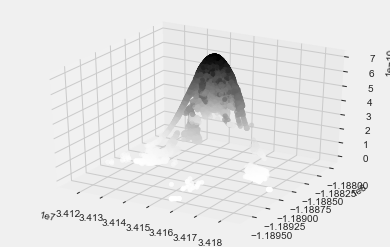

In [33]:
ax=plt.subplot(111,projection='3d')
ax.scatter(properties_city_41673.latitude,
          properties_city_41673.longitude,
          properties_city_41673.GS_outlier_prob,c=properties_city_41673.GS_outlier_prob)

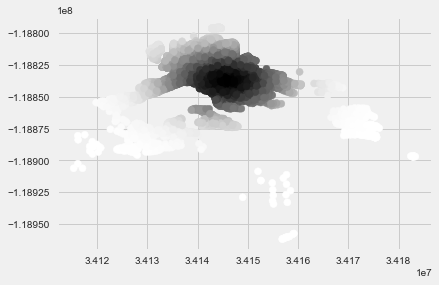

In [16]:
ax = plt.subplot(111)
ax.scatter(properties_city_41673.latitude,
          properties_city_41673.longitude,
          c=properties_city_41673.GS_outlier_prob)

(1e-18, 1e-09)

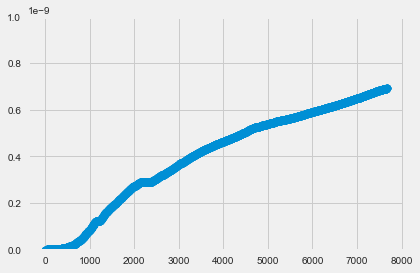

In [32]:
ax = plt.subplot(111)
ind = range(properties_city_41673.shape[0])
ax.scatter(ind, properties_city_41673.GS_outlier_prob.sort_values())
ax.set_ylim([1e-18,1e-9])

不是很奏效

### knn检测

In [35]:
from sklearn.neighbors import KNeighborsClassifier

In [38]:
properties.columns

Index(['parcelid', 'airconditioningtypeid', 'architecturalstyletypeid',
       'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid',
       'unitcnt', 'yardbuildingsqft17', 'yardbuildingsqft26'

In [43]:
tmp = properties[['region_city','latitude','longitude']].dropna().copy()
knn = KNeighborsClassifier()
knn.fit(tmp[['latitude','longitude']].values,tmp.region_city.values)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [44]:
tmp['pcity'] = knn.predict(tmp[['latitude','longitude']].values)

In [45]:
tmp_city_41673 = tmp[tmp.region_city==41673].copy()

In [47]:
tmp_city_41673[tmp_city_41673.region_city!=tmp_city_41673.pcity]

,region_city,latitude,longitude,pcity
402570,41673.0,34156822.0,-118961927.0,34278.0
402633,41673.0,34182411.0,-118896588.0,34278.0
1071589,41673.0,34168884.0,-118842924.0,34278.0
1592366,41673.0,34159154.0,-118957429.0,34278.0
2721810,41673.0,34158994.0,-118957876.0,34278.0
2930323,41673.0,34182916.0,-118896409.0,34278.0


In [55]:
tmp_city_41673['error'] = 0
tmp_city_41673.loc[tmp_city_41673[tmp_city_41673.region_city!=tmp_city_41673.pcity].index, 'error'] = 1

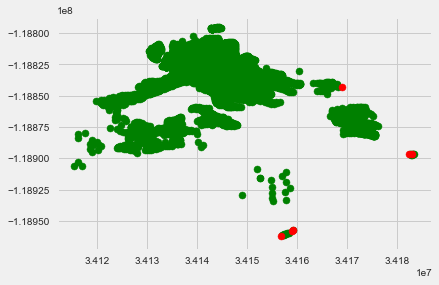

In [58]:
plt.scatter(tmp_city_41673[tmp_city_41673['error']==0].latitude,
           tmp_city_41673[tmp_city_41673['error']==0].longitude,c='g')
plt.scatter(tmp_city_41673[tmp_city_41673['error']==1].latitude,
           tmp_city_41673[tmp_city_41673['error']==1].longitude,c='r')

依然不是很满意